Copyright 2024 Google, LLC. This software is provided as-is,
without warranty or representation for any use or purpose. Your
use of it is subject to your agreement with Google.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Gemini Chat with Image Output

This notebook provides a simple example for interacting with Google's Gemini models to generate inspirational images. For more info visit https://developers.googleblog.com/en/experiment-with-gemini-20-flash-native-image-generation/

Import python libraries

In [32]:
import asyncio
import base64
import contextlib
import datetime
import os
import json
import itertools
import yaml

import nest_asyncio

from IPython.display import Image, display, Markdown
from PIL import Image
from io import BytesIO

from google import genai
from google.genai import types


## Set variables for your environment 

For this example we are going to use AI Stuido. Create a Gemini API Key by going to https://aistudio.google.com/ and add it to the parameters.yaml file.

In [ ]:
parameters_file = 'parameters.yaml'

In [33]:
with open(parameters_file, 'r') as f:
    parameters_data = yaml.safe_load(f)

In [34]:
#print(parameters_data['GeminiKey'])

We'll save the API key in the parameters.yaml file to the GEMINI_API_KEY variable.

In [35]:
GEMINI_API_KEY = parameters_data['GeminiKey']

Initialze the genai client using your API key.

In [36]:
client = genai.Client(api_key=GEMINI_API_KEY)

## Simple Chat Session

Let's define the parameters for the chat session. We'll specify the model and response modalities here.

In [38]:
chat = client.chats.create(model="gemini-2.0-flash-exp-image-generation",
        config=types.GenerateContentConfig(
            response_modalities=["Text", "Image"]
        )
    )

At the time of this example, when using Image and Text outputs we can't directly set system instructions. With that in mind, we can initialize a the session with an initial prompt before performing the While loop for the chat session.

In [37]:
sys_instruct=f'''
You are a personal shopping assistant for a home furnishing company. Your primay goal is to quickly identify the customer's intent and style preferences.
Ask only 1-2 follow up questions to determine their style preferences and then generate a sample image.
The sample image should show the product in a full environment, like a couch in a living room, bedroom suit in a bed room, etc.
'''

In [39]:
chat.send_message(sys_instruct)

GenerateContentResponse(candidates=[Candidate(content=Content(parts=[Part(video_metadata=None, thought=None, code_execution_result=None, executable_code=None, file_data=None, function_call=None, function_response=None, inline_data=None, text="Good morning! Thank you for reaching out to Wayfair. I'm happy to assist you today.\n\nTo get started, could you please tell me what type of item you are looking to purchase today?")], role='model'), citation_metadata=None, finish_message=None, token_count=None, avg_logprobs=None, finish_reason=<FinishReason.STOP: 'STOP'>, grounding_metadata=None, index=0, logprobs_result=None, safety_ratings=None)], create_time=None, response_id=None, model_version='gemini-2.0-flash-exp-image-generation', prompt_feedback=None, usage_metadata=GenerateContentResponseUsageMetadata(cached_content_token_count=None, candidates_token_count=42, prompt_token_count=148, total_token_count=190), automatic_function_calling_history=[], parsed=None)

## While loop for more advanced chat session

Now that we started the session with an initial prompt, we'll start a While loop for the interactive chat session.

Model (Text Part): It looks like you might be interested in a brown leather sofa! Given your past interest in the Mid-Century Modern style, would you prefer a brown leather sofa with a similar clean, classic silhouette, perhaps with tapered legs? Or are you envisioning a different style, maybe something more traditional or modern?
--------------------


Enter your prompt here (or 'End' to quit):  clean and classic 


--------------------
Model (Text Part): Great! Based on your preference for a clean and classic style, and your likely interest in a brown leather sofa, here's a sample image showcasing a **three-seater brown top-grain leather sofa with a clean, classic silhouette and tapered legs** in a well-lit living room setting. It's paired with a simple coffee table and a textured rug to create a timeless and comfortable space.


--------------------


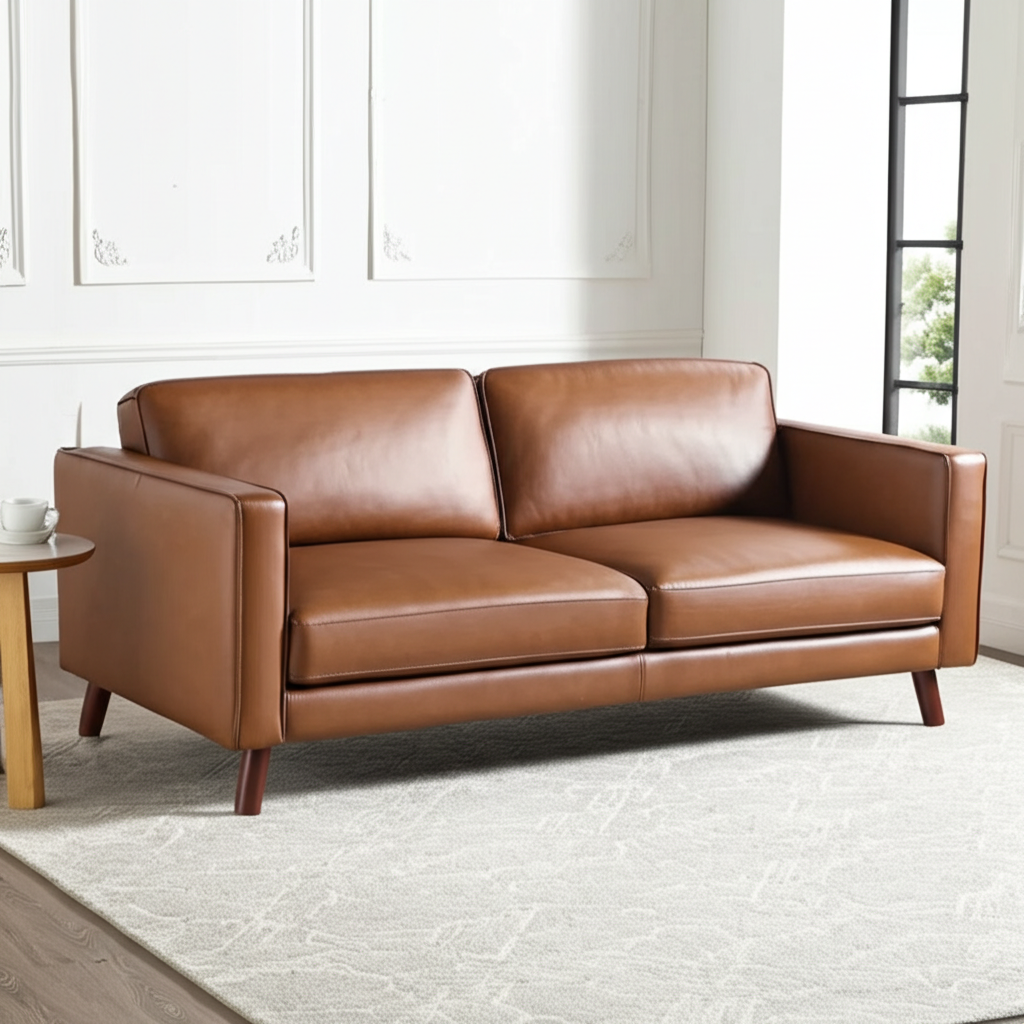

--------------------
Model (Text Part): 

Does this style align with what you had in mind?
--------------------


Enter your prompt here (or 'End' to quit):  OK, that looks nice. let's add a coffee table 


--------------------
Model (Text Part): Okay, great! To complement the clean and classic style of the brown leather sofa, are you thinking of a coffee table with a similar aesthetic – perhaps something with clean lines and a simple material like wood or glass? Or would you prefer something with a touch more detail, like a metal frame or a stone top?
--------------------


Enter your prompt here (or 'End' to quit):  similar look and feel


--------------------
Model (Text Part): Excellent. In keeping with the clean and classic look, here's an image featuring the brown leather sofa with a **simple, rectangular wooden coffee table with clean lines**. The pairing maintains a cohesive and timeless aesthetic for the living room space.


--------------------


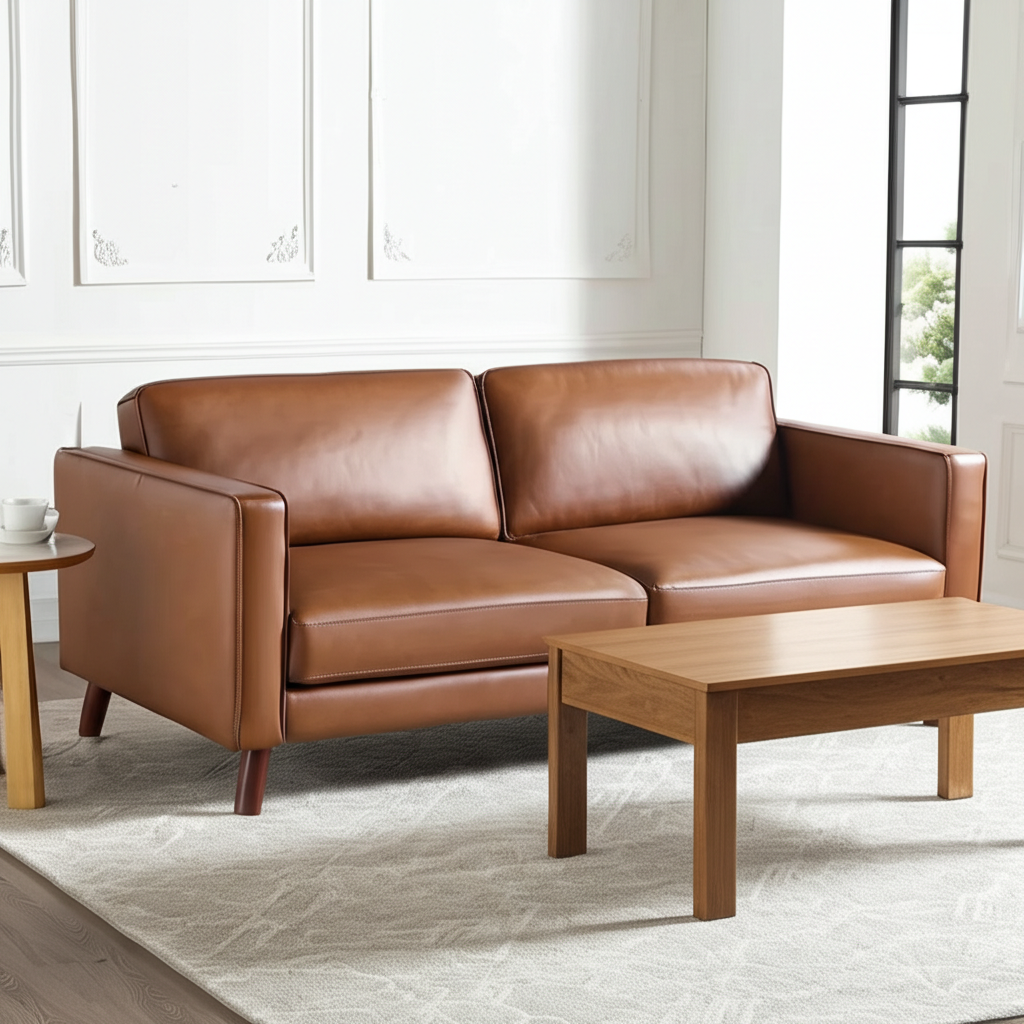

--------------------
Model (Text Part): 

How does this coffee table style look with the sofa?
--------------------


Enter your prompt here (or 'End' to quit):  OK, I like this. My house has green walls. what would that look like


--------------------
Model (Text Part): Okay, let's visualize that for you. Here's the same brown leather sofa and clean-lined wooden coffee table now shown in a living room setting with **soft green walls**. This should give you a better idea of how these furniture pieces might look within your existing home decor.


--------------------


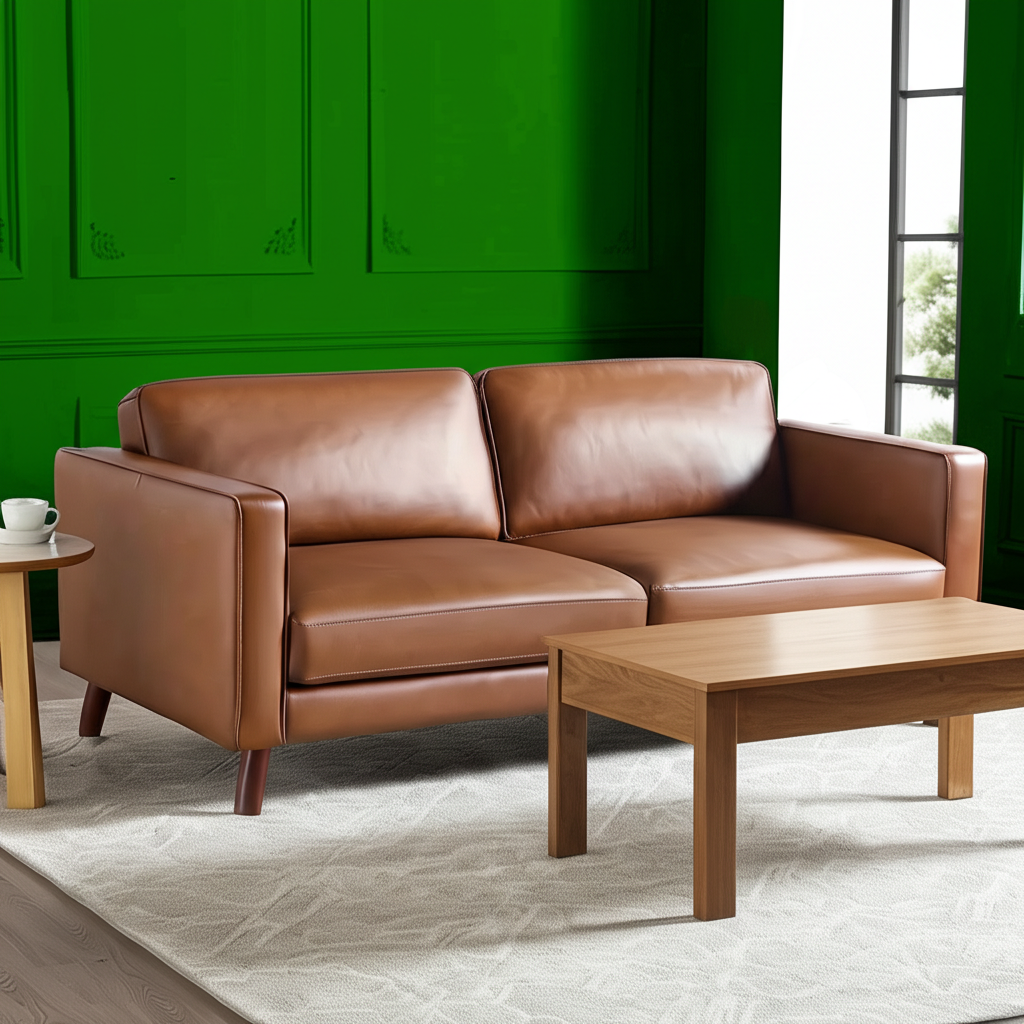

--------------------
Model (Text Part): 

What do you think of this combination with your green walls?
--------------------


Enter your prompt here (or 'End' to quit):  I really like that look


--------------------
Model (Text Part): Wonderful! I'm glad to hear that. Based on your preferences, I can now start showing you specific brown leather sofas and similar style coffee tables that we have in stock. Would you like me to begin browsing those options for you? Perhaps we can start with three-seater brown leather sofas with a clean, mid-century inspired design?
--------------------


Enter your prompt here (or 'End' to quit):  end


--------------------
Chat ended.


In [11]:
response = chat.send_message(f'''
Start your conversation with a formal greeting and ask question to identify what the customer is shopping for.
''')
print("Model (Text Part):", response.text)
print("-" * 20)

while True:
    user_input = input("Enter your prompt here (or 'End' to quit): ")
    print("-" * 20)

    if user_input.lower() == "end":
        print("Chat ended.")
        break

    try:
        response = chat.send_message(user_input)

        # Good practice: write the FULL response to a file for debugging
        with open("my_file.txt", "w") as file:
            file.write(str(response))

        # --- Corrected Image and Text Handling ---
        if response.candidates and response.candidates[0].content:
            # Iterate through ALL parts in the response
            for part in response.candidates[0].content.parts:
                if part.text:  # Check if the part has text
                    print("Model (Text Part):", part.text)
                    print("-" * 20)

                if part.inline_data:  # Check if the part has inline_data (image)
                    try:
                        byte_stream = BytesIO(part.inline_data.data)
                        gen_image = Image.open(byte_stream)  # Open directly
                        # gen_image = gen_image.convert("RGB")  # Only convert if you DON'T want alpha
                        display(gen_image)
                        print("-" * 20)
                    except Exception as e:
                        print(f"Error displaying image: {e}")
        else:
             print("No candidates or content found in the response.")
    except Exception as e:
        print(f"An error occurred: {e}")
        break

In [15]:
chat_history = ""
for message in chat.get_history():
    chat_history += f"role - {message.role}: {message.parts[0].text}\n"

In [16]:
chat_review = client.models.generate_content(
    model="gemini-2.0-flash-exp",
    contents=(
        "Review the following chat history. Identify the user's intent and style preference. Provide an overview of the interaction and overall sentiment from the user. Chat History: "+chat_history
    ),
    config=types.GenerateContentConfig(
        response_modalities=["Text", "Image"]
    ),
)

In [17]:
#print(chat_review.text)
display(Markdown(chat_review.text))

**User's Intent:**

The user's primary intent is to shop for living room furniture, specifically a brown leather sofa and a coffee table that complements it. Their initial openness to suggestions narrows down to a preference for a "clean and classic" style. They are also interested in visualizing how the furniture would look in their home environment, specifically with green walls.

**User's Style Preference:**

The user explicitly states a preference for a "clean and classic" style. This is further supported by:

*   The model's suggestion of "Mid-Century Modern" based on past purchases, which the user doesn't directly reject and the subsequent "clean and classic" direction aligns with some aspects of that style.
*   Their positive reaction to a simple, rectangular wooden coffee table with clean lines.
*   No indication of interest in more ornate, traditional, or highly modern/contemporary styles.

**Overview of the Interaction:**

The interaction follows a logical flow, guided by the personal shopping assistant model.

1.  **Initial Greeting and Broad Inquiry:** The model starts with a formal greeting and asks the user about their shopping needs.
2.  **Leveraging Profile Data:** The model effectively uses the provided user profile data (past purchases and favorite categories) to make an educated guess about the user's potential interests.
3.  **Incorporating PLA Data:** The PLA data strongly suggests the user is actively searching for a "brown leather sofa," which the model quickly picks up on.
4.  **Targeted Follow-Up Questions:** The model asks focused follow-up questions (limited to 1-2 as instructed) to understand the user's style preferences after identifying the product type.
5.  **Image Generation for Visualization:** The model successfully generates sample images showing the products in a relevant environment, allowing the user to visualize the furniture.
6.  **Iterative Refinement:** The user provides feedback ("that looks nice," "similar look and feel," "I really like that look"), and the model adjusts the subsequent suggestions and visualizations accordingly.
7.  **Transition to Product Browsing:** The interaction concludes with the model offering to start showing the user specific products based on their established preferences.

**Overall Sentiment from the User:**

The overall sentiment from the user is **positive and engaged**. Key indicators include:

*   **Direct and Clear Responses:** The user provides concise and understandable answers to the model's questions.
*   **Positive Affirmations:** Phrases like "OK, that looks nice," "I like this," and "I really like that look" clearly indicate satisfaction with the model's suggestions and the generated visuals.
*   **Progression Towards Purchase:** The user's willingness to explore adding a coffee table and visualizing the furniture in their home suggests a genuine interest in making a purchase.
*   **No Negative Feedback or Objections:** The user does not express any dissatisfaction or disagreement with the model's approach or suggestions.

In summary, the user came with an implicit interest in living room furniture, which was quickly refined to a brown leather sofa based on the PLA data. They have a preference for a "clean and classic" style and appreciate the ability to visualize the furniture in a realistic setting. Their positive responses throughout the interaction suggest a successful initial engagement with the personal shopping assistant.